# Plan description and events processing

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\sysmo-data-pt
%matplotlib inline

D:\sysmo-data-pt


In [2]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matsim
import folium
import shapely
from lib import workers as workers

## 1. Load plans

In [3]:
# Data location
batch = 0
plans_file = f'dbs/output/plans_{batch}.csv.gz'
df_plans = pd.read_csv(plans_file, compression='gzip')
df_plans.head()

,act_purpose,PId,act_end,act_id,mode,POINT_X,POINT_Y,dep_time,src,score,trav_time,trav_time_min,act_time,distance,speed
0,home,4,07:23:29,0,NaN,682207.5837,6.615982e+06,00:00:00,input,0.0,0:00:00,0.000000,263.490223,0.000000,NaN
1,work,4,18:07:55,1,car,678634.0963,6.608211e+06,07:23:29,input,0.0,0:10:10,10.172454,634.262011,10.566047,62.321525
2,home,4,18:19:37,2,car,682207.5837,6.615982e+06,18:07:55,input,0.0,0:10:10,10.172454,1.528735,10.577621,62.389789
3,other,4,18:49:26,3,car,673385.2078,6.595261e+06,18:19:37,input,0.0,0:10:10,10.172454,19.641309,28.887319,170.385546
4,other,4,19:19:15,4,car,673274.0032,6.595406e+06,18:49:26,input,0.0,0:10:10,10.172454,19.641309,0.646546,3.813511


### 1.1 Individual examples

In [4]:
def plot_activity_plan(df=None, agent_id=None):
    color_dict = {
    'H': 'tab:green',
    'c': 'tab:gray',
    'W': 'tab:blue',
    'w': 'tab:brown',
    'O': 'tab:orange',
    'S': 'tab:purple',
    'b': 'tab:olive',
    'p': 'tab:cyan',
    'i': 'black'
    }
    
    fig, ax = plt.subplots(figsize=(10, 1))
     
    # Setting Y-axis limits
    ax.set_xlim(0, 25)
    ax.set_ylim(-2, 2)
    ax.broken_barh(list(zip(df.time_start, df.time)), (-1, 2), 
                   facecolors =[color_dict[x] for x in df.act])
    for x1, x2, act in df[['time_start', 'time', 'act']].values:
        ax.text(x=x1 + x2/2,  
                y=0,
                s=act, 
                ha='center', 
                va='center',
                color='white',
                )
    ax.set_xticks([np.floor(x) for x in df.time_start] + [24], 
              labels=['%.0f'%np.floor(x) for x in df.time_start] + [24]) 
    ax.set_yticks([0], labels=[f'Agent {agent_id}']) 
    plt.box(on=None)
    plt.show()
    
def restructure_plan(df_plan=None):
    act_mapping = {'work': 'W', 'home': 'H', 'other': 'O', 'school': 'S',
                   'car': 'c', 'walk': 'w', 'pt': 'p', 'bike': 'b', 'pt interaction': 'i'}
    df = pd.DataFrame()
    L = len(df_plan)
    df.loc[:, 'seq'] = range(1, L*2)
    df.loc[:, 'time'] = np.stack(df_plan[['trav_time_min', 'act_time']].values, axis=0).reshape(L*2, 1)[1:]
    df.loc[:, 'time_start'] = np.hstack((0, df.loc[:, 'time'].cumsum().values[:-1]))
    df.loc[:, 'time'] /= 60
    df.loc[:, 'time_start'] /= 60
    act_seq = np.stack((df_plan.act_purpose.values[:-1],
                        df_plan['mode'].values[1:]), axis=-1).reshape((L-1)*2, 1)
    act_seq = np.insert(act_seq, len(act_seq), df_plan.act_purpose.values[-1])
    df.loc[:, 'act'] = [act_mapping[x] for x in act_seq]
    return df

In [7]:
inds = df_plans.PId.unique()

array([nan, 'car', 'walk', 'pt', 'bike'], dtype=object)

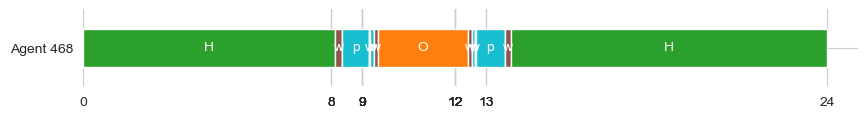

In [12]:
ind = inds[67]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

In [13]:
plot_activity_plan(df=restructure_plan(df_plan=df_plans.loc[(df_plans.PId==ind) & (df_plans.src=='input'), :]), agent_id=ind)

,act_purpose,PId,act_end,act_id,mode,POINT_X,POINT_Y,dep_time,src,score,trav_time,trav_time_min,act_time,distance,speed
6175299,home,468,8:08:05,0,NaN,0.000000,0.000000e+00,0:00:00,output,96.186968,00:00:00,0.000000,488.083333,0.000000,NaN
6175300,pt interaction,468,8:20:27,1,walk,681904.894495,6.615627e+06,8:08:05,output,96.186968,00:12:22,12.366667,0.000000,0.617683,2.996846
6175301,pt interaction,468,9:13:54,2,pt,674565.120455,6.582694e+06,8:20:27,output,96.186968,00:53:27,53.450000,0.000000,36.996661,41.530396
6175302,pt interaction,468,9:15:08,3,walk,674525.059159,6.582663e+06,9:13:54,output,96.186968,00:01:14,1.233333,0.000000,0.066000,3.210811
6175303,pt interaction,468,9:23:07,4,pt,674985.334671,6.581394e+06,9:15:08,output,96.186968,00:08:00,8.000000,0.000000,1.685575,12.641809
6175304,other,468,12:24:17,5,walk,674716.177200,6.581539e+06,9:23:07,output,96.186968,00:07:57,7.950000,173.200000,0.397407,2.999300
6175305,pt interaction,468,12:32:14,6,walk,674985.334671,6.581394e+06,12:24:17,output,96.186968,00:07:57,7.950000,0.000000,0.397407,2.999300
6175306,pt interaction,468,12:38:20,7,pt,674524.030999,6.582663e+06,12:32:14,output,96.186968,00:06:07,6.116667,0.000000,1.686648,16.544779
6175307,pt interaction,468,12:39:36,8,walk,674563.994750,6.582696e+06,12:38:20,output,96.186968,00:01:16,1.266667,0.000000,0.067000,3.173684
6175308,pt interaction,468,13:35:46,9,pt,681904.894495,6.615627e+06,12:39:36,output,96.186968,00:56:09,56.150000,0.000000,36.991006,39.527344


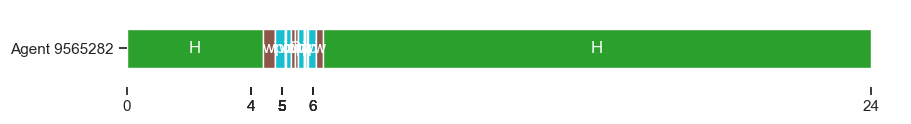

In [88]:
plot_activity_plan(df=restructure_plan(df_plan=df_plans.loc[(df_plans.PId==9565282) & (df_plans.src=='output'), :]), agent_id=9565282)

## 2. Sanity check on PT usage

In [9]:
df_plans_ind

,act_purpose,PId,act_end,act_id,mode,POINT_X,POINT_Y,dep_time,src,score,trav_time,trav_time_min,act_time,distance,speed
8444463,home,628,7:41:38,0,NaN,0.000000,0.000000e+00,0:00:00,output,64.088529,00:00:00,0.000000,461.633333,0.000000,NaN
8444464,pt interaction,628,8:03:17,1,walk,680536.023430,6.546624e+06,7:41:38,output,64.088529,00:21:39,21.650000,0.000000,1.082171,2.999087
8444465,pt interaction,628,11:02:37,2,pt,667281.450181,6.541235e+06,8:03:17,output,64.088529,02:59:21,179.350000,0.000000,22.911620,7.664885
8444466,pt interaction,628,11:04:33,3,walk,667370.048216,6.541165e+06,11:02:37,output,64.088529,00:01:55,1.916667,0.000000,0.147000,4.601739
8444467,pt interaction,628,11:52:40,4,pt,669838.652334,6.534032e+06,11:04:33,output,64.088529,00:48:07,48.116667,0.000000,8.930522,11.136086
8444468,school,628,17:21:50,5,walk,669847.440400,6.533787e+06,11:52:40,output,64.088529,00:06:23,6.383333,322.800000,0.318340,2.992230
8444469,pt interaction,628,17:34:40,6,walk,670071.886451,6.533348e+06,17:21:50,output,64.088529,00:12:50,12.833333,0.000000,0.641412,2.998808
8444470,pt interaction,628,18:04:02,7,pt,667281.450181,6.541235e+06,17:34:40,output,64.088529,00:29:22,29.366667,0.000000,10.059633,20.553166
8444471,pt interaction,628,18:07:58,8,walk,667469.967958,6.541169e+06,18:04:02,output,64.088529,00:03:55,3.916667,0.000000,0.260000,3.982979
8444472,pt interaction,628,19:11:09,9,pt,680040.908656,6.546143e+06,18:07:58,output,64.088529,01:03:12,63.200000,0.000000,22.164088,21.041856


In [22]:
def one_column_distr(data=None, col=None, col_name=None):   #, xticks=[1, 10, 100, 1000, 2000]
    median_value = data[col].median()
    sns.set(style="ticks")
    f, ax = plt.subplots(figsize=(7, 5))
    sns.despine(f)
    
    # Create the line plot
    sns.histplot(
        data,
        x=col,
        edgecolor=".3",
        linewidth=.5,
        bins=100,
        stat='proportion',
        ax=ax
    )
    ax.axvline(median_value, linestyle='--', label='Median=%.2f'%median_value)
    sns.despine()
    # Enhance the plot
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    # ax.set_xticks(xticks)
    plt.legend(frameon=False)
    plt.xlabel(col_name)
    plt.ylabel('Fraction of trips')

### 2.1 Public transport

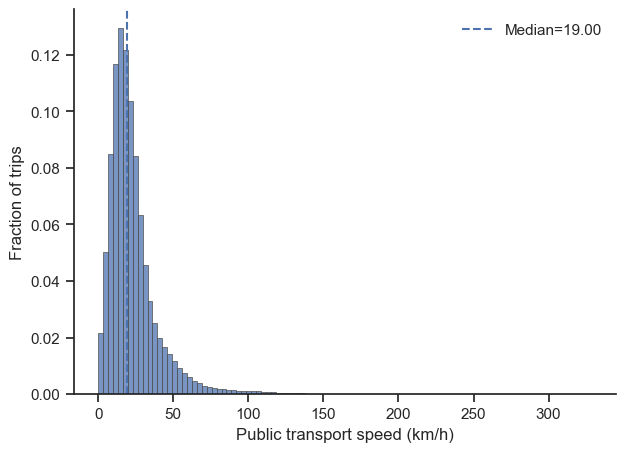

In [42]:
data2show = df_plans.loc[(df_plans['mode']=='pt') & (df_plans['src']=='output'), :].replace([np.inf, -np.inf], np.nan).dropna()
one_column_distr(data=data2show, col='speed', col_name='Public transport speed (km/h)')

### 2.2 Walking speed

In [46]:
data2show = df_plans.loc[(df_plans['mode']=='walk') & (df_plans['src']=='output'), :].replace([np.inf, -np.inf], np.nan).dropna()
no_abnormal = data2show.loc[data2show['speed'] > 10, 'PId'].nunique() / df_plans.PId.nunique() * 100
print(f"Share of individuals have abnormal walking speed above 10 km/h: {no_abnormal} %")

Share of individuals have abnormal walking speed above 10 km/h: 0.7797211727720456 %


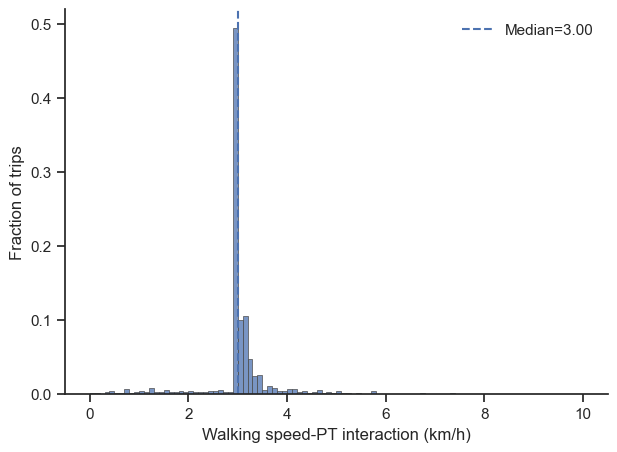

In [49]:
one_column_distr(data=data2show.loc[(data2show['speed'] <= 10) & (data2show['act_purpose'] == 'pt interaction'), :], 
                 col='speed', col_name='Walking speed-PT interaction (km/h)')

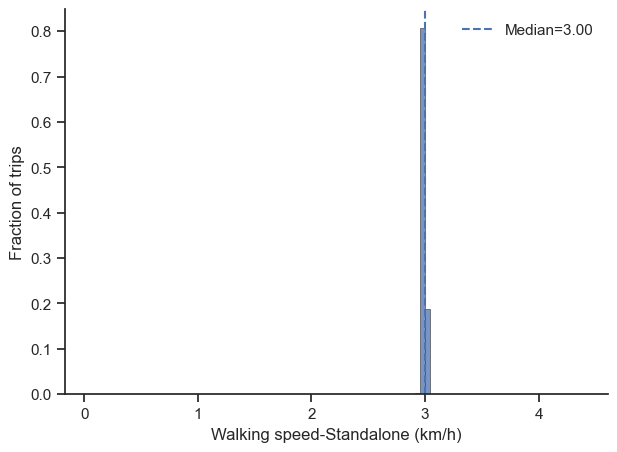

In [50]:
one_column_distr(data=data2show.loc[(data2show['speed'] <= 10) & (data2show['act_purpose'] != 'pt interaction'), :], 
                 col='speed', col_name='Walking speed-Standalone (km/h)')

### 2.3 Biking speed

In [53]:
data2show = df_plans.loc[(df_plans['mode']=='bike') & (df_plans['src']=='output'), :].replace([np.inf, -np.inf], np.nan).dropna()
no_abnormal = data2show.loc[data2show['speed'] > 40, 'PId'].nunique() / df_plans.PId.nunique() * 100
print(f"Share of individuals have abnormal biking speed above 40 km/h: {no_abnormal} %")

Share of individuals have abnormal biking speed above 40 km/h: 0.0 %


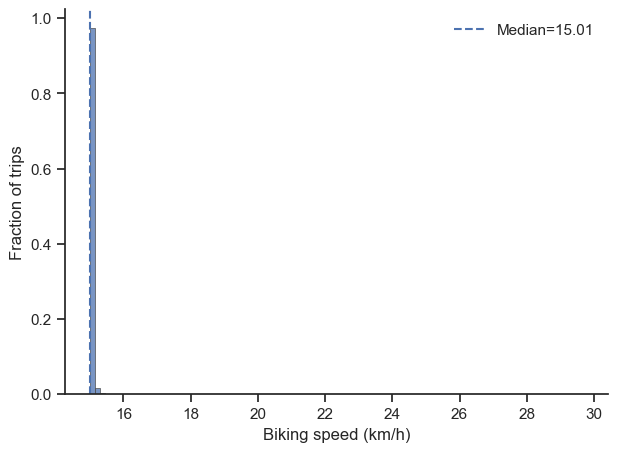

In [56]:
one_column_distr(data=data2show.loc[data2show['speed'] <= 40, :], 
                 col='speed', col_name='Biking speed (km/h)')

## 3. Network

In [57]:
# read network
input_file = 'dbs/scenarios/sweden/output_1/output_network.xml.gz'
net = matsim.read_network(input_file)
geo = net.as_geo()  # combines links+nodes into a Geopandas dataframe with LINESTRINGs

In [58]:
geo.head()

,length,freespeed,capacity,permlanes,oneway,modes,link_id,from_node,to_node,geometry
0,481.239929,11.111111,600.0,1.0,1,car,10,441557672,442330933,"LINESTRING (374101.255 6258377.983, 374133.899..."
1,36.365222,4.166667,600.0,1.0,1,car,100,6159514954,1801777826,"LINESTRING (441341.551 6522798.063, 441346.658..."
2,45.748284,4.166667,600.0,1.0,1,car,1000,7098624155,5304929876,"LINESTRING (455508.389 6929779.879, 455553.788..."
3,45.066036,2.777778,300.0,1.0,1,car,10000,1431711158,1431711274,"LINESTRING (662344.523 6571560.838, 662335.462..."
4,10.098473,6.944444,600.0,1.0,1,car,100000,9682588781,9682001659,"LINESTRING (658965.901 6635300.797, 658969.266..."


In [59]:
geo.modes.unique()

array(['car', 'car,bus', 'pt,bus', 'pt,car,bus', 'train,rail,pt', 'rail',
       'rail,light_rail,pt', 'pt,light_rail,bus', 'pt,tram,bus', 'bus',
       'rail,tram,pt', 'tram,pt,car,bus', 'pt', 'rail,tram,pt,bus',
       'pt,rail,bus', 'rail,light_rail,pt,bus', 'artificial,bus',
       'rail,artificial', 'stopFacilityLink,artificial,ferry',
       'ferry,artificial', 'stopFacilityLink,artificial,bus',
       'stopFacilityLink,artificial,rail',
       'stopFacilityLink,artificial,tram', 'tram,artificial',
       'artificial,rail,stopFacilityLink,bus',
       'stopFacilityLink,artificial,subway', 'subway,artificial',
       'artificial,ferry,stopFacilityLink,bus'], dtype=object)

<Axes: >

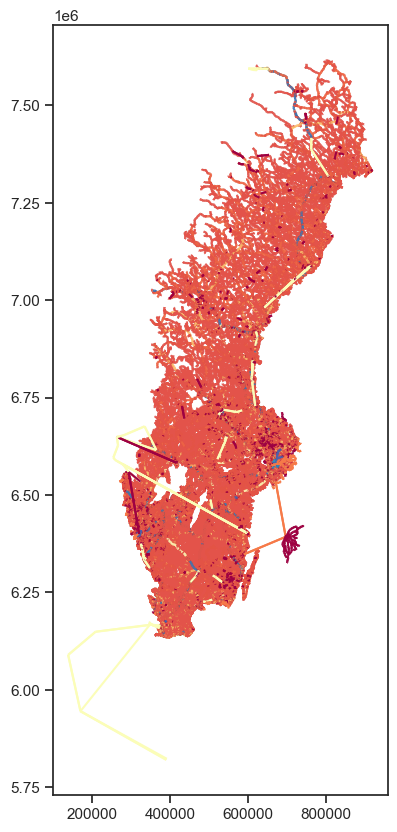

In [60]:
geo.plot(column='modes', figsize=(10,10), categorical=True, cmap='Spectral') #cmap is colormap

In [45]:
batch = 0
file_path2output = os.path.join(f'dbs/scenarios/sweden/output_{batch}/output_events.xml.gz')
selected_types = ['actend', 'actstart', 'vehicle enters traffic',
                  'left link', 'vehicle leaves traffic']
selected_vars = ['person', 'vehicle', 'time', 'type', 'link']
events = matsim.event_reader(file_path2output)  # , types=','.join(selected_types)
events_list = []
count2write = 0
for event in tqdm(events, desc='Streaming events'):
    events_list.append(event)
    count2write += 1
    if count2write > 2000000:
        df2write = pd.DataFrame.from_records(events_list)
        # df2write.loc[:, 'person'] = df2write.loc[:, 'person'].fillna(df2write.loc[:, 'vehicle'])
        break

Streaming events: 2000000it [00:16, 120336.09it/s]


In [46]:
print(df2write.type.unique())

['actend' 'departure' 'travelled' 'arrival' 'actstart'
 'TransitDriverStarts' 'PersonEntersVehicle' 'vehicle enters traffic'
 'VehicleArrivesAtFacility' 'VehicleDepartsAtFacility' 'left link'
 'entered link' 'waitingForPt' 'vehicle leaves traffic'
 'PersonLeavesVehicle']


In [47]:
df2write.columns

Index(['time', 'type', 'person', 'link', 'x', 'y', 'actType', 'legMode',
       'computationalRoutingMode', 'distance', 'mode', 'driverId', 'vehicleId',
       'transitLineId', 'transitRouteId', 'departureId', 'vehicle',
       'networkMode', 'relativePosition', 'facility', 'delay', 'agent',
       'atStop', 'destinationStop'],
      dtype='object')

In [48]:
selected_types = ['actend', 'actstart', 'vehicle enters traffic',
                  'left link', 'vehicle leaves traffic', 'PersonEntersVehicle', 'PersonLeavesVehicle']
selected_vars = ['person', 'vehicle', 'time', 'type', 'actType', 'link', 'vehicleId']

In [51]:
df2write_refined = df2write.loc[df2write['type'].isin(['left link']), selected_vars]
df2write_refined.head()

,person,vehicle,time,type,actType,link,vehicleId
1951,NaN,veh_127179_rail,421.0,left link,NaN,1372389,NaN
1959,NaN,veh_127179_rail,425.0,left link,NaN,451304,NaN
2003,NaN,veh_127179_rail,441.0,left link,NaN,973215,NaN
2071,NaN,veh_127179_rail,472.0,left link,NaN,1271352,NaN
2086,NaN,veh_127179_rail,475.0,left link,NaN,1271346,NaN


## 4. Events processing

In [3]:
# Create event batches
for batch in range(0, 10):
    print(f'Processing batch {batch}:')
    workers.matsim_events2parquet(region='sweden', batch=batch, test=False)

Processing batch 0:


Streaming events: 175459269it [1:01:46, 47343.42it/s] 


Processing batch 1:


Streaming events: 174943010it [1:01:01, 47778.85it/s] 


Processing batch 2:


Streaming events: 175592256it [55:42, 52530.11it/s] 


Processing batch 3:


Streaming events: 176091301it [59:51, 49034.01it/s] 


Processing batch 4:


Streaming events: 175193944it [57:52, 50452.72it/s] 


Processing batch 5:


Streaming events: 175817484it [59:55, 48904.27it/s] 


Processing batch 6:


Streaming events: 175582843it [57:27, 50928.59it/s] 


Processing batch 7:


Streaming events: 175819191it [57:15, 51177.35it/s] 


Processing batch 8:


Streaming events: 175861168it [57:00, 51413.37it/s] 


Processing batch 9:


Streaming events: 175091510it [55:08, 52923.24it/s] 


## 5. Events visualization

In [8]:
# Load events
df_events = pd.read_parquet('dbs/output/events_0.parquet')
# Load network
input_file = 'dbs/scenarios/sweden/output_1/output_network.xml.gz'
net = matsim.read_network(input_file)
geo = net.as_geo()  # combines links+nodes into a Geopandas dataframe with LINESTRINGs
gdf = pd.merge(df_events, geo[['link_id', 'geometry']].rename(columns={'link_id': 'link'}), on='link', how='left')

In [32]:
def events_map(gdf_events=None, df_plan=None):
    # Process the data to get centroid
    gdf_events = gdf_events.dropna(subset=['geometry'])
    gdf_events = gpd.GeoDataFrame(gdf_events, geometry='geometry').to_crs(4326)
    gdf_events['points'] = gdf_events.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
    points = []
    for x in gdf_events['points'].values:
        points += x
    gdf_points = gpd.GeoDataFrame({}, geometry=[shapely.geometry.Point(x[0], x[1]) for x in points])
    center = gdf_points.dissolve().centroid
    center = [center.y.values[0], center.x.values[0]]
    # Prepare plans locations
    gdf_plans_ind = workers.df2gdf_point(df_plan, x_field='POINT_X', y_field='POINT_Y',
                                     crs=3006, drop=True)
    gdf_plans_ind.dropna(inplace=True)
    gdf_plans_ind = gdf_plans_ind.to_crs(4326)
    gdf_plans_ind.loc[:, 'latitude'] = gdf_plans_ind.geometry.y
    gdf_plans_ind.loc[:, 'longitude'] = gdf_plans_ind.geometry.x
    
    # Put on the map
    color_dict = {
        'home': 'green',
        'work': 'blue',
        'other': 'orange',
        'school': 'purple',
        'pt interaction': 'black'
    }
    m = folium.Map(location=center, zoom_start=12)
 
    folium.Choropleth(
        gdf_events,
        line_weight=3,
        line_color='steelblue'
    ).add_to(m)
    gdf_plans_ind.apply(lambda row : folium.CircleMarker(
        location=(row["latitude"], row["longitude"]), radius=3, 
        fill_color=color_dict[row['act_purpose']], 
        popup=row['act_purpose'],
        color=color_dict[row['act_purpose']]).add_to(m), axis=1)
    return m

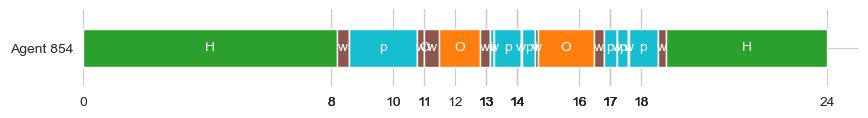

In [43]:
ind = inds[90]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

In [44]:
df_events_ind = gdf.loc[gdf.person==str(ind), :]
m = events_map(gdf_events=df_events_ind, df_plan=df_plans_ind)
m